Index(['FECHA_INFRACCION', 'TOTAL_HI'], dtype='object')
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=866.128, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=865.869, Time=0.53 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=865.815, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=864.660, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=868.125, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=868.125, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=869.466, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=863.994, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=865.869, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=867.282, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=865.947, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=865.941, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=863.

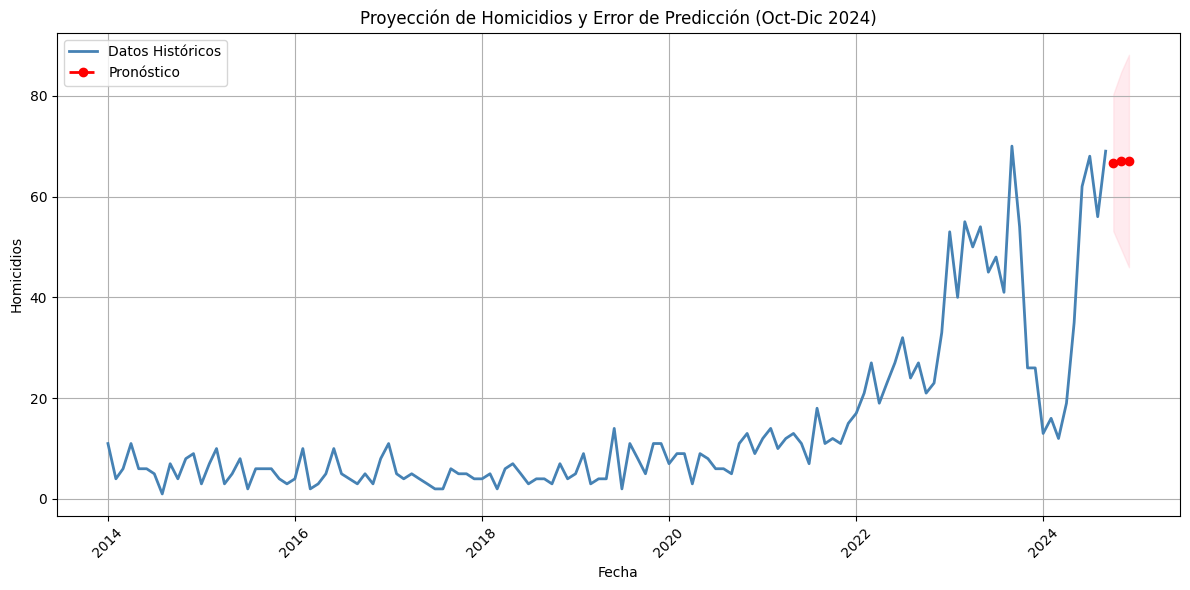

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# 1. Cargar los datos
df = pd.read_excel("BDD/mdi_homicidios_intencionales_pm_2014-2023.xlsx",
                    sheet_name="bdd_hi_el_oro")

# Verificar nombres de columnas
print(df.columns)

# Convertir columna de fecha al índice
df["FECHA_INFRACCION"] = pd.to_datetime(df["FECHA_INFRACCION"])  # Convertir la columna 'fecha' a formato datetime
df.set_index("FECHA_INFRACCION", inplace=True)  # Establecer 'fecha' como índice

# 2. Ajuste automático del modelo ARIMA
modelo_auto = auto_arima(df["TOTAL_HI"], seasonal=True, m=12, trace=True)

# 3. Entrenamiento del modelo SARIMA
modelo_sarima = SARIMAX(df["TOTAL_HI"],
                        order=modelo_auto.order,
                        seasonal_order=modelo_auto.seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
resultado = modelo_sarima.fit()  # Ajuste del modelo

# 4. Predicción a futuro para octubre, noviembre y diciembre de 2024
pred_periodos = 3  # Predicción para 3 meses (octubre, noviembre y diciembre de 2024)
pred = resultado.get_forecast(steps=pred_periodos)
pred_conf = pred.conf_int()

# Crear un rango de fechas para los meses de octubre, noviembre y diciembre de 2024
fechas_pred = pd.date_range(start="2024-10-01", periods=pred_periodos, freq='MS')

# 5. Crear un DataFrame con los pronósticos
df_pred = pd.DataFrame({
    'Fecha': fechas_pred,
    'Real': [None] * pred_periodos,  # No hay datos reales para estos meses aún
    'Pronóstico': pred.predicted_mean,
    'Error': [None] * pred_periodos,  # Los errores no se pueden calcular sin los valores reales
    'Confianza Inferior': pred_conf.iloc[:, 0],
    'Confianza Superior': pred_conf.iloc[:, 1]
})

# 6. Agregar los pronósticos al DataFrame original usando pd.concat
df_pred.set_index('Fecha', inplace=True)  # Asegurarse de que la fecha sea el índice
df_combined = pd.concat([df, df_pred])  # Concatenar los DataFrames

# 7. Calcular los errores de predicción para los datos históricos
# Solo calculamos los errores para los datos que ya están disponibles (no para los meses futuros)
df_combined['Error'] = df_combined['TOTAL_HI'] - df_combined['Pronóstico']

# Mostrar la tabla condensada
print(df_combined[['TOTAL_HI', 'Pronóstico', 'Error', 'Confianza Inferior', 'Confianza Superior']])

# 8. Visualización de la serie con la predicción y el intervalo de confianza
plt.figure(figsize=(12, 6))
plt.plot(df_combined['TOTAL_HI'], label="Datos Históricos", color="steelblue", linewidth=2)
plt.plot(df_combined['Pronóstico'], label="Pronóstico", color="red", marker="o", linestyle="--", linewidth=2)
plt.fill_between(df_combined.index, df_combined['Confianza Inferior'], df_combined['Confianza Superior'], 
                 color="pink", alpha=0.3)
plt.legend()
plt.title("Proyección de Homicidios y Error de Predicción (Oct-Dic 2024)")
plt.xlabel("Fecha")
plt.ylabel("Homicidios")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df_combined

,TOTAL_HI,Real,Pronóstico,Error,Confianza Inferior,Confianza Superior
2014-01-01,11.0,NaN,NaN,NaN,NaN,NaN
2014-02-01,4.0,NaN,NaN,NaN,NaN,NaN
2014-03-01,6.0,NaN,NaN,NaN,NaN,NaN
2014-04-01,11.0,NaN,NaN,NaN,NaN,NaN
2014-05-01,6.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-08-01,56.0,NaN,NaN,NaN,NaN,NaN
2024-09-01,69.0,NaN,NaN,NaN,NaN,NaN
2024-10-01,NaN,None,66.709976,NaN,53.133514,80.286437
2024-11-01,NaN,None,67.113377,NaN,49.522980,84.703773
